# EXPLORED EDA - TIME SERIES

In [3]:
# -------------------------------
# IMPORTS
# -------------------------------

# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Decompose time-series in 3 components: trend, seasonal and resid
from statsmodels.tsa.seasonal import seasonal_decompose
# To evaluate the seasonality of the time series we can apply the so-called Dickey-Fuller test
# It is a hypothesis test in which the null hypothesis is that the series is stationary
# The alternative, that it is non-stationary:
from statsmodels.tsa.stattools import adfuller
# Autocorrelation is the correlation of a time series with a lagged copy of itself.
# This graph helps us see if the values ​​in the time series are correlated with previous values.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#ARIMA model
from statsmodels.tsa.arima.model import ARIMA
# Automate the selection of the best parameters for an ARIMA model, saving time compared to manual tuning.
from pmdarima import auto_arima

In [57]:

def log(message: str, level: int = 1, type: str = "INFO", custom_icon: str = None):
    # Default icons according to message type
    icons = {
        "INFO": "ℹ️",
        "FOUND": "🔍",
        "SUCCESS": "✅",
        "ERROR": "❌",
        "WARNING": "⚠️",
    }

    # Use custom icon if provided
    if custom_icon:
        icon = custom_icon
    else:
        icon = icons.get(type.upper(), "ℹ️")

    # First level → bullet
    if level == 1:
        prefix = "•"
    
    # Second level → indent + hyphen
    elif level == 2:
        prefix = "   -"
    
    # Fallback
    else:
        prefix = "-"
    
    # Final print
    print(f"{prefix} {icon} {message}")


## STEP 0 - LOAD RAW DATAFRAME

In [19]:
# Raw dataset formatting
data_separator = ","
input_path = "../data/raw/internal-link.csv"
# Thresholds for dataset type proposal (text detection)
min_text_avg_length = 25      # Recommended: 20–30 chars → typical minimum for real text
min_text_avg_words  = 3       # Recommended: >3 words → avoids titles/labels

In [38]:
print("STEP 0) LOAD RAW DATAFRAME")

# Load raw DataFrame
df_raw = pd.read_csv(input_path, sep=data_separator)
log("DataFrame loaded successfully!", type="SUCCESS")

# ---------------------------------------------------------
# NLP CHECKING (probabilistic)
# ---------------------------------------------------------
log("NLP cheking:", custom_icon="📝")
nlp_score = 0            # Final probability score (0–100)
nlp_diag = []            # Diagnostic report

# Evidence 1: dataset has at least one text-like column
object_cols = []
for col in df_raw.columns:
    if df_raw[col].dtype in ["object", "category"]:
        object_cols.append(col)
if len(object_cols) >= 1:
    nlp_score += 25
    log(f"Object-type columns found: {object_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No object-type columns found", level=2, type="ERROR")

# Evidence 2: long text columns exist
text_cols = []
for col in object_cols:
    avg_len = df_raw[col].dropna().str.len().mean()
    if avg_len is not None and avg_len > min_text_avg_length:
        text_cols.append(col)
if len(text_cols) >= 1:
    nlp_score += 25
    log(f"Long text-like columns found: {text_cols} -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 3: rich text structure (words per entry)
rich_text_cols = []
for col in text_cols:
    avg_words = df_raw[col].dropna().str.split().str.len().mean()
    if avg_words is not None and avg_words > min_text_avg_words:
        rich_text_cols.append(col)
if len(rich_text_cols) > 0:
    nlp_score += 25
    log(f"At least one column shows word-rich entries -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No column shows word-rich entries", level=2, type="ERROR")

# Evidence 4: number of text columns realistic for NLP
if len(text_cols) == 1:
    nlp_score += 15
    log(f"There is only 1 long text-like column, it is typical for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
elif len(text_cols) > 1:
    nlp_score += 5
    log(f"There are more than 1 long text-like column, it could be possible for NLP -> + {nlp_score}%", level=2, type="SUCCESS")
else:
    log("No long text-like columns found", level=2, type="ERROR")

# Evidence 5: proportion of non-empty text entries
if len(text_cols) >= 1:
    non_empty_ratio = df_raw[text_cols[0]].dropna().str.len().gt(10).mean()
    if non_empty_ratio >= 0.6:
        nlp_score += 10
        log(f"Majority of rows contain meaningful text -> + {nlp_score}%", level=2, type="SUCCESS")
    else:
        log("Too many empty/short text entries", level=2, type="ERROR")

# Cap score at 100
nlp_score = min(nlp_score, 100)
log(f"Probability score to be a NLP Dataset: {nlp_score}%", level=2, type="INFO")

# ---------------------------------------------------------
# TIME-SERIES CHECKING (probabilistic)
# ---------------------------------------------------------
log("TIME-SERIES cheking:", custom_icon="⏱️")
ts_score = 0              # Final probability score (0–100)
ts_col = None             # Name of the detected datetime column
ts_diag = []              # Diagnostic text list

# Evidence 1: dataset has a datetime column
datetime_cols = []
for col in df_raw.columns:
    try:
        pd.to_datetime(df_raw[col], errors="raise")
        datetime_cols.append(col)
    except:
        pass
if len(datetime_cols) == 1:
    ts_score += 40
    ts_col = datetime_cols[0]
    log(f"A unique datetime column was detected -> + {ts_score}%", level=2, type="SUCCESS")
elif len(datetime_cols) >1:
    ts_score += 25
    ts_col = datetime_cols[0]
    log(f"Several datetime columns were detected -> + {ts_score}%", level=2, type="SUCCESS")
else:
    log("No datetime column found", level=2, type="ERROR")

# Evaluate time-series structure only if a datetime column exists
if ts_col is not None:
    dt_series = pd.to_datetime(df_raw[ts_col], errors="coerce")

    # Evidence 2: sorted chronological order
    if dt_series.is_monotonic_increasing:
        ts_score += 20
        log(f"Datetime column is chronologically sorted -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log("Datetime column is not sorted", level=2, type="ERROR")

    # Evidence 3: regular frequency
    diffs = dt_series.diff().dropna()
    if len(diffs) > 0:
        most_common_delta = diffs.mode()[0]
        freq_ratio = (diffs == most_common_delta).mean()

        if freq_ratio >= 0.7:
            ts_score += 20
            log(f"Regular frequency detected -> + {ts_score}%", level=2, type="SUCCESS")
        else:
            log("No regular frequency detected", level=2, type="ERROR")
    else:
        log("Not enough data points to assess frequency", level=2, type="ERROR")

    # Evidence 4: numeric metrics over time
    numeric_cols = df_raw.select_dtypes(include=["number"]).columns
    if 1 <= len(numeric_cols) <= 5:
        ts_score += 10
        log(f"Numeric variables suitable for time-series analysis -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log("Numeric structure does not strongly suggest a time-series", level=2, type="ERROR")

    # Evidence 5: dataset length
    if len(df_raw) >= 50:
        ts_score += 10
        log(f"Dataset contains enough rows to form a time-series -> + {ts_score}%", level=2, type="SUCCESS")
    else:
        log("Dataset too short to be a time-series", level=2, type="ERROR")

# Cap score at 100
ts_score = min(ts_score, 100)
log(f"Probability score to be a TIME-SERIES Dataset: {ts_score}%", level=2, type="INFO")


# Propose dataset type
if ts_score >= nlp_score and ts_score>= 75:
    dataset_type_auto = "TIME-SERIES"
elif nlp_score >= ts_score and nlp_score>= 75:
    dataset_type_auto = "NLP"
else:
    dataset_type_auto = "TABULAR"
log(f"Proposed dataset type: {dataset_type_auto}", type="INFO")

STEP 0) LOAD RAW DATAFRAME
• ✅ DataFrame loaded successfully!
• 📝 NLP cheking:
   - ✅ Object-type columns found: ['date'] -> + 25%
   - ✅ Long text-like columns found: ['date'] -> + 50%
   - ❌ No column shows word-rich entries
   - ✅ There is only 1 long text-like column, it is typical for NLP -> + 65%
   - ✅ Majority of rows contain meaningful text -> + 75%
   - ℹ️ Probability score to be a NLP Dataset: 75%
• ⏱️ TIME-SERIES cheking:
   - ✅ Several datetime columns were detected -> + 25%
   - ✅ Datetime column is chronologically sorted -> + 45%
   - ✅ Regular frequency detected -> + 65%
   - ✅ Numeric variables suitable for time-series analysis -> + 75%
   - ✅ Dataset contains enough rows to form a time-series -> + 85%
   - ℹ️ Probability score to be a TIME-SERIES Dataset: 85%
• ℹ️ Proposed dataset type: TIME-SERIES


## STEP 1 - EXPLORE DATAFRAME

In [60]:
dataset_type = "TIME-SERIES" # Confirm dataset type (TIME-SERIES, NLP or TABULAR)

STEP 1) EXPLORE DATAFRAME
• ⏱️ Dataset detected as TIME-SERIES
• ℹ️ Shape of the DataFrame: (366, 2)
• ℹ️ Content of the DataFrame:


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


• ℹ️ Time index information:
   - 📅 Detected time column: 'date'
   - 📅 Start date: 2022-09-03 17:10:08.079328
   - 📅 End date: 2023-09-03 17:10:08.079328
   - 📅 Total duration: 365 days 00:00:00
• ℹ️ Estimated sampling frequency:
   - ⏳ Most common delta: 1 days 00:00:00
   - ⏳ Regular frequency ratio: 1.00
• ℹ️ Numeric metrics detected:
   - 📈 sales
• ℹ️ Basic statistics per numeric variable:


,count,mean,std,min,25%,50%,75%,max
sales,366.0,524.963968,275.089698,53.803211,290.186822,520.699468,763.289263,1000.482785


• ℹ️ Temporal trend sample (first 10 rows):


,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
5,2022-09-08 17:10:08.079328,60.081865
6,2022-09-09 17:10:08.079328,68.466704
7,2022-09-10 17:10:08.079328,67.765106
8,2022-09-11 17:10:08.079328,70.512261
9,2022-09-12 17:10:08.079328,74.656453


• ✅ Quick plot generated


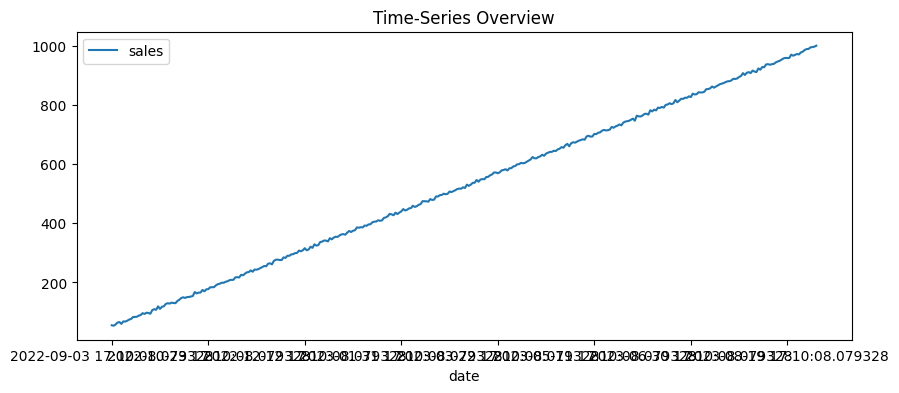

In [ ]:
# -------------------------------
# STEP 1) EXPLORE DATAFRAME
# -------------------------------
print("STEP 1) EXPLORE DATAFRAME")

# Copy original DataFrame
df_S1 = df_raw.copy()

# -------------------------------
# NLP DATASET
# -------------------------------
if dataset_type == "NLP":
    log("Dataset detected as NLP (long-text dataset)", custom_icon="📝")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Sample of raw text entries:", type="INFO")
    display(df_S1[text_cols].head(5))

    # Print text length stats
    df_lengths = df_S1[text_cols[0]].astype(str).str.len()
    log("Text length statistics:", type="INFO")
    log(f"Average lengths: {df_lengths.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median lengths: {df_lengths.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max lengths: {df_lengths.max():.1f} chars", level=2, custom_icon="📊")

    # Compute word statistics
    df_words = df_S1[text_cols[0]].astype(str).str.split().str.len()
    log("Word count statistics:", type="INFO")
    log(f"Average words: {df_words.mean():.1f} chars", level=2, custom_icon="📊")
    log(f"Median words: {df_words.median():.1f} chars", level=2, custom_icon="📊")
    log(f"Max words: {df_words.max():.1f} chars", level=2, custom_icon="📊")

# -------------------------------
# TIME-SERIES DATASET
# -------------------------------
elif dataset_type == "TIME-SERIES":
    log("Dataset detected as TIME-SERIES", custom_icon="⏱️")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))

    # Time column
    time_col = datetime_cols[0]
    dt_series = pd.to_datetime(df_S1[time_col], errors="coerce")

    log("Time index information:", type="INFO")
    log(f"Detected time column: '{time_col}'", level=2, custom_icon="📅")
    log(f"Start date: {dt_series.min()}", level=2, custom_icon="📅")
    log(f"End date: {dt_series.max()}", level=2, custom_icon="📅")
    log(f"Total duration: {dt_series.max() - dt_series.min()}", level=2, custom_icon="📅")

    # Estimate frequency
    diffs = dt_series.diff().dropna()
    if len(diffs) > 0:
        most_common_delta = diffs.mode()[0]
        log("Estimated sampling frequency:", type="INFO")
        log(f"Most common delta: {most_common_delta}", level=2, custom_icon="⏳")
        log(f"Regular frequency ratio: {(diffs == most_common_delta).mean():.2f}", level=2, custom_icon="⏳")
    else:
        log("Not enough data points to estimate frequency", type="WARNING")

    # Missing or irregular timestamps
    missing_ratio = 1 - (diffs == most_common_delta).mean() if len(diffs) > 0 else None
    if missing_ratio is not None and missing_ratio > 0.10:
        log("Irregular timestamps detected (missing or uneven intervals)", type="WARNING")
        log(f"Irregularity ratio: {missing_ratio:.2f}", level=2, custom_icon="⚠️")

    # Numeric metrics
    numeric_cols = df_S1.select_dtypes(include=["number"]).columns
    log("Numeric metrics detected:", type="INFO")
    for col in numeric_cols:
        log(f"{col}", level=2, custom_icon="📈")

    # Statistics for each metric
    log("Basic statistics per numeric variable:", type="INFO")
    display(df_S1[numeric_cols].describe().T)

    # Trend preview (optional small sample)
    log("Temporal trend sample (first 10 rows):", type="INFO")
    display(df_S1[[time_col] + list(numeric_cols)].head(10))

# -------------------------------
# TABULAR DATASET
# -------------------------------
elif dataset_type == "TABULAR":
    log("Dataset detected as TABULAR", custom_icon="🧮")

    # Print info
    log(f"Shape of the DataFrame: {df_S1.shape}", type="INFO")
    log("Content of the DataFrame:", type="INFO")
    display(df_S1.head(5))
    log("Info of the DataFrame (dataType and non-null values):", type="INFO")
    df_S1.info(verbose=True, show_counts=True)

    # Ordered info (fewest non-null first)
    ordered_info = pd.DataFrame({
        "Column": df_S1.columns,
        "Non-Null Count": df_S1.notnull().sum(),
        "Null Count": df_S1.isnull().sum(),
        "Dtype": df_S1.dtypes.astype(str)
    }).sort_values(by="Non-Null Count", ascending=True)
    log("Ordered info by number of non-null values:", type="INFO")
    display(ordered_info)

    # Count unique attributes (unsorted)
    df_S1_summary = pd.DataFrame({
        "Column": df_S1.columns,
        "Unique_Count": df_S1.nunique().values
    })
    log("DataFrame unique attributes (unsorted):", type="INFO")
    display(df_S1_summary)

    # Ordered summary (fewest unique first)
    df_S1_summary_ordered = df_S1_summary.sort_values(by="Unique_Count", ascending=True)
    log("Ordered unique attributes (fewest unique first):", type="INFO")
    display(df_S1_summary_ordered)

    # Automatic Warning for high-uniqueness columns
    unique_counts = df_S1.nunique()
    high_unique_cols = unique_counts[unique_counts == len(df_S1)].index.tolist()
    if len(high_unique_cols) > 0:
        log("Consider dropping the following columns for having UNIQUE values for EVERY row:", type="WARNING")
        for col in high_unique_cols:
            log(f"{col}", level=2, custom_icon="🗑️")

STEP 2) BUILD TIME INDEX
• ⏱️ Building a robust time-series index
• 🔍 Detected temporal column: 'date'
• ℹ️ Temporal granularity detection:
   - 🕒 Smallest interval found: 1 days 00:00:00
   - 🕒 Most common interval: 1 days 00:00:00
   - 🕒 Detected temporal granularity: day
• ✅ Indexed DataFrame by 'date' (column dropped to avoid duplication)
• ℹ️ Preview of time-indexed DataFrame:


,sales
date,
2022-09-03 17:10:08.079328,55.292157
2022-09-04 17:10:08.079328,53.803211
2022-09-05 17:10:08.079328,58.141693
2022-09-06 17:10:08.079328,64.530899
2022-09-07 17:10:08.079328,66.013633


• ✅ Extracted target time-series 'sales'


date
2022-09-03 17:10:08.079328    55.292157
2022-09-04 17:10:08.079328    53.803211
2022-09-05 17:10:08.079328    58.141693
2022-09-06 17:10:08.079328    64.530899
2022-09-07 17:10:08.079328    66.013633
Name: sales, dtype: float64

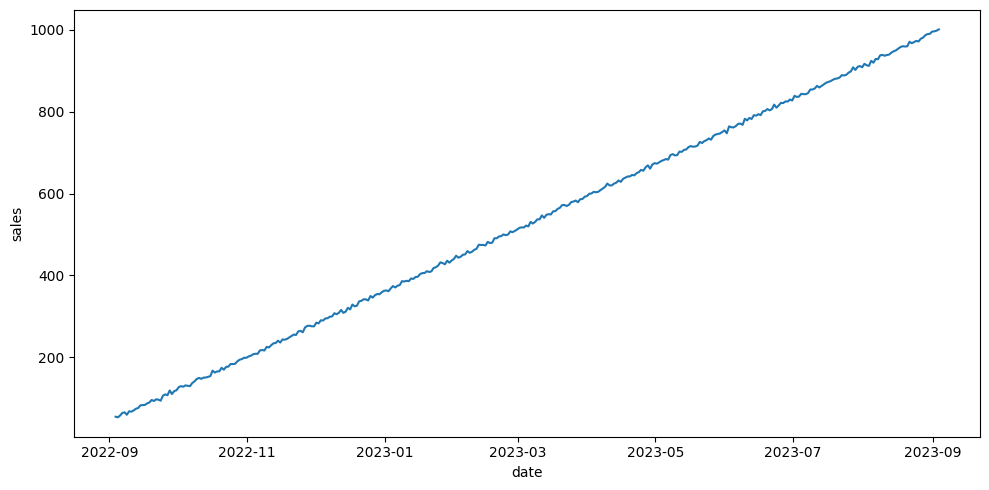

In [73]:
# -------------------------------
# STEP 2) BUILD TIME INDEX
# -------------------------------
print("STEP 2) BUILD TIME INDEX")

# Copy previous DataFrame
df_S2 = df_S1.copy()

if dataset_type == "TIME-SERIES":

    log("Building a robust time-series index", custom_icon="⏱️")

    # ----------------------------------------
    # 1) Identify the temporal column
    # ----------------------------------------
    if len(datetime_cols) > 0:
        time_col = datetime_cols[0]
        log(f"Detected temporal column: '{time_col}'", type="FOUND")
    else:
        log("No temporal column found → cannot build time index", type="ERROR")
        time_col = None

    # Stop if no datetime column exists
    if time_col is None:
        raise ValueError("No datetime column found → cannot build time index.")

    # Convert to datetime
    df_S2[time_col] = pd.to_datetime(df_S2[time_col], errors="coerce")

    # ----------------------------------------
    # 2) Sort by datetime just in case
    # ----------------------------------------
    df_S2 = df_S2.sort_values(by=time_col)

    # ----------------------------------------
    # 3) Detect temporal granularity
    # ----------------------------------------
    diffs = df_S2[time_col].diff().dropna()

    if len(diffs) == 0:
        log("Not enough data to detect time granularity", type="ERROR")

    else:
        # Compute smallest delta
        min_delta = diffs.min()

        # Compute most common delta (mode)
        most_common_delta = diffs.mode().iloc[0]

        log("Temporal granularity detection:", type="INFO")
        log(f"Smallest interval found: {min_delta}", level=2, custom_icon="🕒")
        log(f"Most common interval: {most_common_delta}", level=2, custom_icon="🕒")

        # ----------------------------------------
        # 4) Classify granularity
        # ----------------------------------------
        # Convert most_common_delta to seconds
        seconds = most_common_delta.total_seconds()

        # Granularity classification (correct version)
        if seconds < 1:
            granularity = "sub-second"

        elif seconds >= 1 and seconds < 60:
            granularity = "second"

        elif seconds >= 60 and seconds < 3600:
            granularity = "minute"

        elif seconds >= 3600 and seconds < 86400:
            granularity = "hour"

        elif seconds == 86400:
            granularity = "day"

        elif seconds > 86400 and seconds <= 86400 * 7:
            granularity = "multi-day"

        elif seconds == 86400 * 7:
            granularity = "week"

        elif seconds > 86400 * 7 and seconds < 86400 * 28:
            granularity = "weekly-to-monthly"

        elif seconds >= 86400 * 28 and seconds <= 86400 * 31:
            granularity = "month"

        elif seconds > 86400 * 31 and seconds <= 86400 * 92:
            granularity = "quarter"

        else:
            granularity = "year-or-more"

        log(f"Detected temporal granularity: {granularity}", level=2, custom_icon="🕒")

    # ----------------------------------------
    # 5) Create date index robustly
    # ----------------------------------------

    # Convert to datetime first
    dt_series = pd.to_datetime(df_S2[time_col], errors="coerce")

    # Drop the column if still present as normal column
    if time_col in df_S2.columns:
        df_S2 = df_S2.drop(columns=[time_col])

    # Assign the datetime index
    df_S2.index = dt_series

    # Make sure the index has a name
    df_S2.index.name = time_col

    log(f"Indexed DataFrame by '{time_col}' (column dropped to avoid duplication)", type="SUCCESS")

    # Show preview
    log("Preview of time-indexed DataFrame:", type="INFO")
    display(df_S2.head(5))

    # ----------------------------------------
    # 6) Extract numeric target series
    # ----------------------------------------
    numeric_cols = df_S2.select_dtypes(include=["number"]).columns

    if len(numeric_cols) > 0:

        # Pick the first numeric column as the time-series
        target_col = numeric_cols[0]
        ts = df_S2[target_col]

        log(f"Extracted target time-series '{target_col}'", type="SUCCESS")
        display(ts.head(5))

    else:
        log("No numeric metrics detected to extract as the main time-series", 
            type="ERROR")
    
    fig, axis = plt.subplots(figsize = (10, 5))

    sns.lineplot(data = ts)

    plt.tight_layout()

    plt.show()
